1. Load the packages and dependencies 

In [ ]:
import cv2

from darknet import Darknet

import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
def load_class_names(namesfile):
    
    # Create an empty list to hold the object classes
    class_names = []
    
    # Open the file containing the COCO object classes in read-only mode
    with open(namesfile, 'r') as fp:
        
        # The coco.names file contains only one object class per line.
        # Read the file line by line and save all the lines in a list.
        lines = fp.readlines()
    
    # Get the object class names
    for line in lines:
        
        # Make a copy of each line with any trailing whitespace removed
        line = line.rstrip()
        
        # Save the object class name into class_names
        class_names.append(line)
        
    return class_names

2. YOLO

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2020-10-22 13:37:51--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  56.9KB/s    in 59m 5s  

2020-10-22 14:36:59 (68.3 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
# Set the location and name of the cfg file
cfg_file = '/content/yolov3.cfg'

# Set the location and name of the pre-trained weights file
weight_file = '/content/yolov3.weights'

# Set the location and name of the COCO object classes file
namesfile = '/content/coco.names'

# Load the network architecture
m = Darknet(cfg_file)

# Load the pre-trained weights
m.load_weights(weight_file)

# Load the COCO object classes
class_names = load_class_names(namesfile)

In [ ]:
# Print the neural network used in YOLOv3
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

3. Non-Max Suppression

In [ ]:
def boxes_iou(box1, box2):
  
    # Get the Width and Height of each bounding box
    width_box1 = box1[2]
    height_box1 = box1[3]
    width_box2 = box2[2]
    height_box2 = box2[3]
    
    # Calculate the area of the each bounding box
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    
    # Find the vertical edges of the union of the two bounding boxes
    mx = min(box1[0] - width_box1/2.0, box2[0] - width_box2/2.0)
    Mx = max(box1[0] + width_box1/2.0, box2[0] + width_box2/2.0)
    
    # Calculate the width of the union of the two bounding boxes
    union_width = Mx - mx
    
    # Find the horizontal edges of the union of the two bounding boxes
    my = min(box1[1] - height_box1/2.0, box2[1] - height_box2/2.0)
    My = max(box1[1] + height_box1/2.0, box2[1] + height_box2/2.0)    
    
    # Calculate the height of the union of the two bounding boxes
    union_height = My - my
    
    # Calculate the width and height of the area of intersection of the two bounding boxes
    intersection_width = width_box1 + width_box2 - union_width
    intersection_height = height_box1 + height_box2 - union_height
   
    # If the the boxes don't overlap then their IOU is zero
    if intersection_width <= 0 or intersection_height <= 0:
        return 0.0

    # Calculate the area of intersection of the two bounding boxes
    intersection_area = intersection_width * intersection_height
    
    # Calculate the area of the union of the two bounding boxes
    union_area = area_box1 + area_box2 - intersection_area
    
    # Calculate the IOU
    iou = intersection_area/union_area
    
    return iou

In [ ]:
def nms(boxes, iou_thresh):
    
    # If there are no bounding boxes do nothing
    if len(boxes) == 0:
        return boxes
    
    # Create a PyTorch Tensor to keep track of the detection confidence
    # of each predicted bounding box
    det_confs = torch.zeros(len(boxes))
    
    # Get the detection confidence of each predicted bounding box
    for i in range(len(boxes)):
        det_confs[i] = boxes[i][4]

    # Sort the indices of the bounding boxes by detection confidence value in descending order.
    # We ignore the first returned element since we are only interested in the sorted indices
    _,sortIds = torch.sort(det_confs, descending = True)
    
    # Create an empty list to hold the best bounding boxes after
    # Non-Maximal Suppression (NMS) is performed
    best_boxes = []
    
    # Perform Non-Maximal Suppression 
    for i in range(len(boxes)):
        
        # Get the bounding box with the highest detection confidence first
        box_i = boxes[sortIds[i]]
        
        # Check that the detection confidence is not zero
        if box_i[4] > 0:
            
            # Save the bounding box 
            best_boxes.append(box_i)
            
            # Go through the rest of the bounding boxes in the list and calculate their IOU with
            # respect to the previous selected box_i. 
            for j in range(i + 1, len(boxes)):
                box_j = boxes[sortIds[j]]
                
                # If the IOU of box_i and box_j is higher than the given IOU threshold set
                # box_j's detection confidence to zero. 
                if boxes_iou(box_i, box_j) > iou_thresh:
                    box_j[4] = 0
                    
    return best_boxes

4. Loading and Resizing Our Images

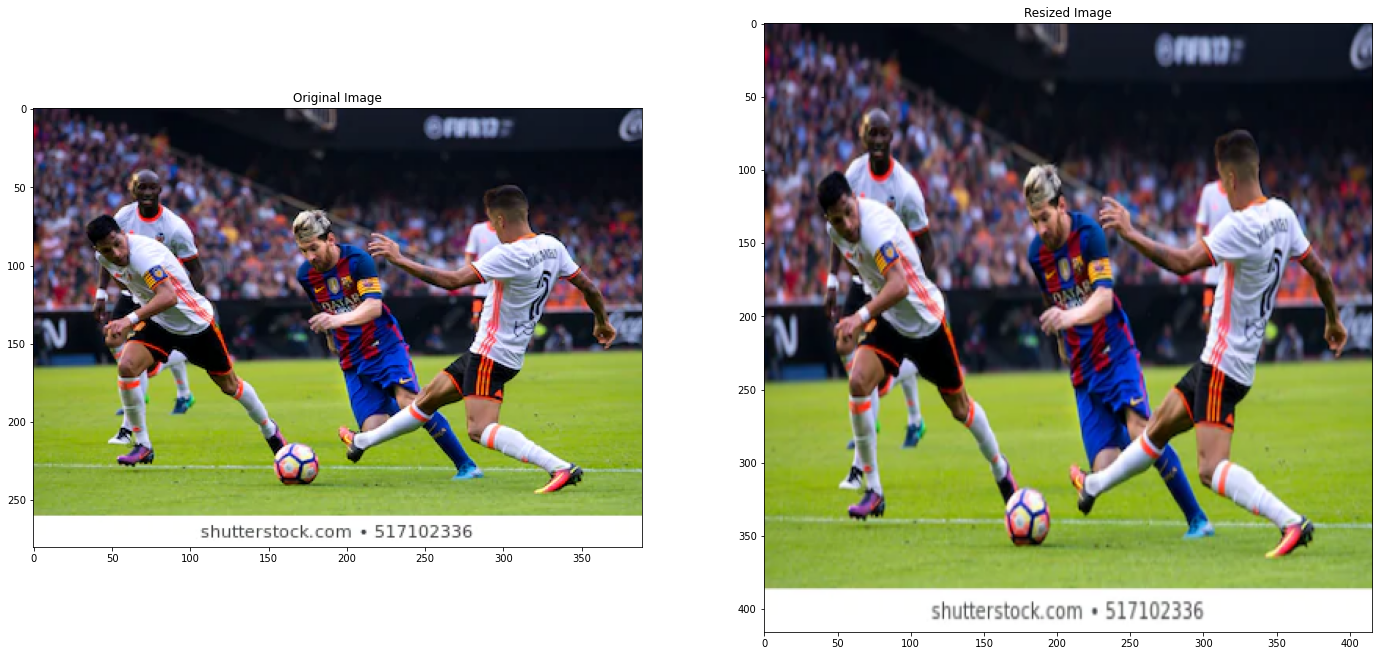

In [ ]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread('/content/test.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

5. Image Segmentation and Crowd Density Estimator

In [ ]:
def detect_objects(model, img, iou_thresh, nms_thresh):
    
    # Start the time. This is done to calculate how long the detection takes.
    start = time.time()
    
    # Set the model to evaluation mode.
    model.eval()
    
    # Convert the image from a NumPy ndarray to a PyTorch Tensor of the correct shape.
    # The image is transposed, then converted to a FloatTensor of dtype float32, then
    # Normalized to values between 0 and 1, and finally unsqueezed to have the correct
    # shape of 1 x 3 x 416 x 416
    img = torch.from_numpy(img.transpose(2,0,1)).float().div(255.0).unsqueeze(0)
    
    # Feed the image to the neural network with the corresponding NMS threshold.
    # The first step in NMS is to remove all bounding boxes that have a very low
    # probability of detection. All predicted bounding boxes with a value less than
    # the given NMS threshold will be removed.
    list_boxes = model(img, nms_thresh)
    
    # Make a new list with all the bounding boxes returned by the neural network
    boxes = list_boxes[0][0] + list_boxes[1][0] + list_boxes[2][0]
    
    # Perform the second step of NMS on the bounding boxes returned by the neural network.
    # In this step, we only keep the best bounding boxes by eliminating all the bounding boxes
    # whose IOU value is higher than the given IOU threshold
    boxes = nms(boxes, iou_thresh)
    
    # Stop the time. 
    finish = time.time()
    
    # Print the time it took to detect objects
    print('\n\nIt took {:.3f}'.format(finish - start), 'seconds to detect the objects in the image.\n')
    
    # Print the number of objects detected
    print('Number of Objects Detected:', len(boxes), '\n')
    
    return boxes

In [ ]:

def print_objects(boxes, class_names):    
    print('Objects Found and Confidence Level:\n')
    for i in range(len(boxes)):
        box = boxes[i]
        if len(box) >= 7 and class_names:
            cls_conf = box[5]
            cls_id = box[6]
            print('%i. %s: %f' % (i + 1, class_names[cls_id], cls_conf))

In [ ]:
def plot_boxes(img, boxes, class_names, plot_labels, color = None):
    
    # Define a tensor used to set the colors of the bounding boxes
    colors = torch.FloatTensor([[1,0,1],[0,0,1],[0,1,1],[0,1,0],[1,1,0],[1,0,0]])
    
    # Define a function to set the colors of the bounding boxes
    def get_color(c, x, max_val):
        ratio = float(x) / max_val * 5
        i = int(np.floor(ratio))
        j = int(np.ceil(ratio))
        
        ratio = ratio - i
        r = (1 - ratio) * colors[i][c] + ratio * colors[j][c]
        
        return int(r * 255)
    
    # Get the width and height of the image
    width = img.shape[1]
    height = img.shape[0]
    
    # Create a figure and plot the image
    fig, a = plt.subplots(1,1)
    a.imshow(img)
    
    # Plot the bounding boxes and corresponding labels on top of the image
    for i in range(len(boxes)):
        
        # Get the ith bounding box
        box = boxes[i]
        
        # Get the (x,y) pixel coordinates of the lower-left and lower-right corners
        # of the bounding box relative to the size of the image. 
        x1 = int(np.around((box[0] - box[2]/2.0) * width))
        y1 = int(np.around((box[1] - box[3]/2.0) * height))
        x2 = int(np.around((box[0] + box[2]/2.0) * width))
        y2 = int(np.around((box[1] + box[3]/2.0) * height))
        
        # Set the default rgb value to red
        rgb = (1, 0, 0)
            
        # Use the same color to plot the bounding boxes of the same object class
        if len(box) >= 7 and class_names:
            cls_conf = box[5]
            cls_id = box[6]
            classes = len(class_names)
            offset = cls_id * 123457 % classes
            red   = get_color(2, offset, classes) / 255
            green = get_color(1, offset, classes) / 255
            blue  = get_color(0, offset, classes) / 255
            
            # If a color is given then set rgb to the given color instead
            if color is None:
                rgb = (red, green, blue)
            else:
                rgb = color
        
        # Calculate the width and height of the bounding box relative to the size of the image.
        width_x = x2 - x1
        width_y = y1 - y2
        
        # Set the postion and size of the bounding box. (x1, y2) is the pixel coordinate of the
        # lower-left corner of the bounding box relative to the size of the image.
        rect = patches.Rectangle((x1, y2),
                                 width_x, width_y,
                                 linewidth = 2,
                                 edgecolor = rgb,
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
        
        # If plot_labels = True then plot the corresponding label
        if plot_labels:
            
            # Create a string with the object class name and the corresponding object class probability
            conf_tx = class_names[cls_id] + ': {:.1f}'.format(cls_conf)
            
            # Define x and y offsets for the labels
            lxc = (img.shape[1] * 0.266) / 100
            lyc = (img.shape[0] * 1.180) / 100
            
            # Draw the labels on top of the image
            a.text(x1 + lxc, y1 - lyc, conf_tx, fontsize = 24, color = 'k',
                   bbox = dict(facecolor = rgb, edgecolor = rgb, alpha = 0.8))        
        
    plt.show()



It took 1.691 seconds to detect the objects in the image.

Number of Objects Detected: 5 

Objects Found and Confidence Level:

1. person: 1.000000
2. person: 1.000000
3. person: 1.000000
4. sports ball: 1.000000
5. person: 1.000000


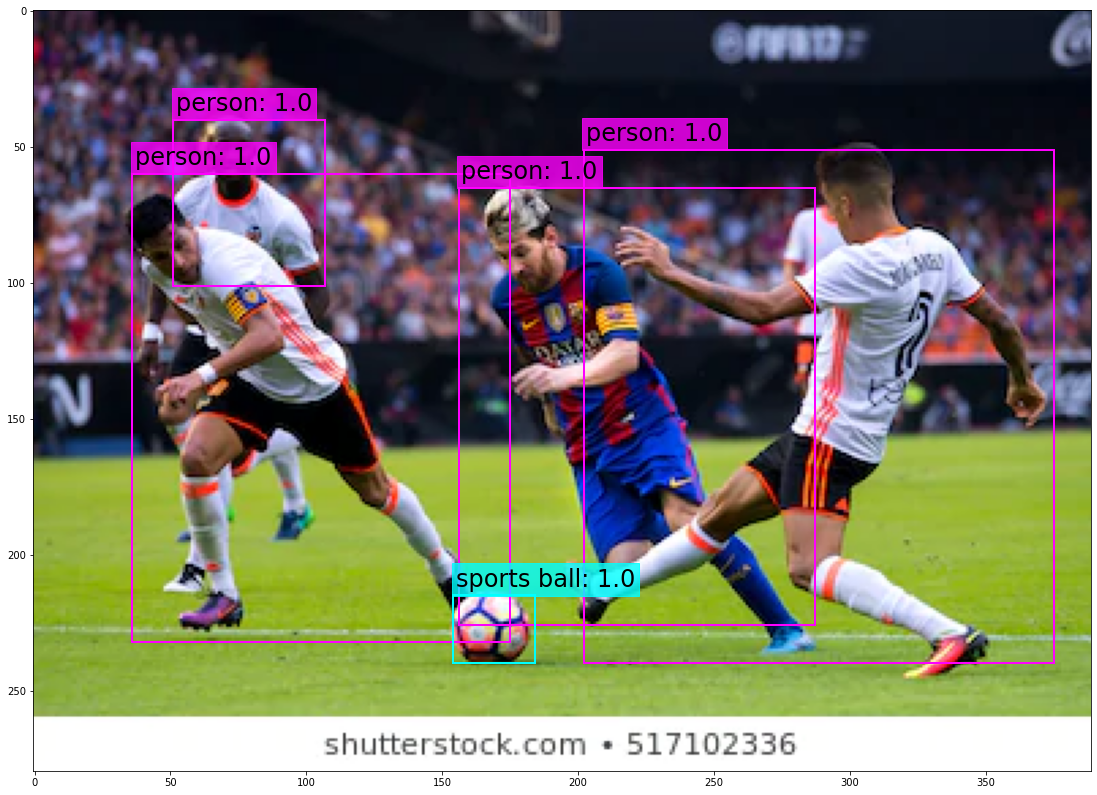

In [ ]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread('/content/test.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Set the IOU threshold. Default value is 0.4
iou_thresh = 0.4

# Set the NMS threshold. Default value is 0.6
nms_thresh = 0.6

# Detect objects in the image
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
print_objects(boxes, class_names)

#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes, class_names, plot_labels = True)